# Packages

In [43]:
%matplotlib notebook

import sys
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import fabio
import pyFAI

import pandas as pd

import h5py

# Paths

In [2]:
path_proj = Path('..', '..', '..', 'DATA_FAST', 'SAXS', 'MARS_CEA_2204')

path_raw = Path(path_proj, "raw")
path_ut = Path(path_proj, "utilities")
path_int = Path(path_proj, "integrated")
path_res = Path(path_proj, "results")

L55_path = Path(path_raw, 'scan_0047_0001.nxs') # Echantillon L55 ODS
Ni_path = Path(path_raw, 'scan_0058_0001.nxs')  # Echantillon base Ni à tester
BdF_path = Path(path_raw, 'scan_0029_0001.nxs') # Bruit de Fond

# Double diff? - Images Ni et L55

<IPython.core.display.Javascript object>


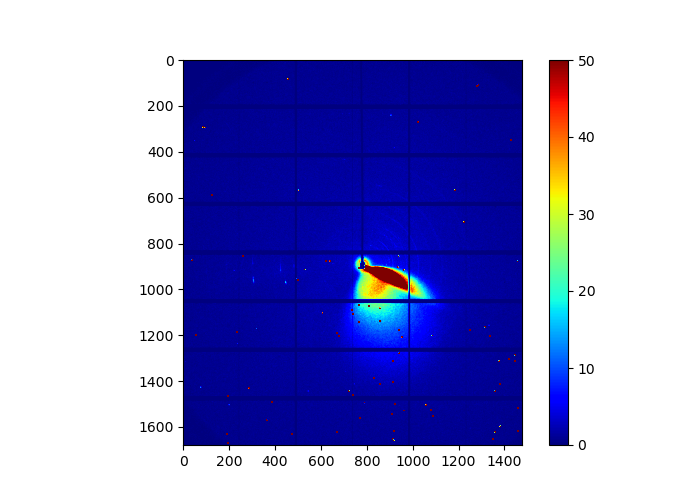

../../../DATA_FAST/SAXS/MARS_CEA_2204/results/L55_image (20, 12).tiff


In [7]:
IMG_path = L55_path
ii = 20
jj = 12

to_save = True
save_path = Path(path_res, f'L55_image ({ii}, {jj}).tiff')

f = h5py.File(IMG_path, "r")
IMGs = f['_']['scan_data']['data_01']

IMG = np.zeros((IMGs.shape[1], IMGs.shape[2]))
IMG = IMGs[ii, jj,:,:]

fig = plt.figure(figsize=(7, 5))
pos = plt.imshow(IMG, cmap='jet')
plt.clim(0, 50)
fig.colorbar(pos)
plt.show()

if to_save:
    plt.savefig(save_path)
    print(save_path)


<IPython.core.display.Javascript object>


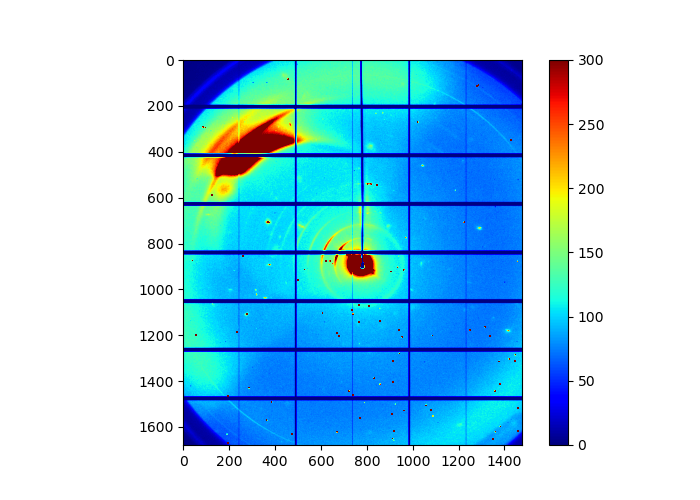

In [19]:
IMG_path = Ni_path
ii = 15
jj = 13


to_save = False
save_path = Path(path_res, f'Ni_image ({ii}, {jj}).tiff')

f = h5py.File(IMG_path, "r")
IMGs = f['_']['scan_data']['data_01']

IMG = np.zeros((IMGs.shape[1], IMGs.shape[2]))
IMG = IMGs[ii, jj,:,:]

fig = plt.figure(figsize=(7, 5))
pos = plt.imshow(IMG, cmap='jet')
plt.clim(0, 300)
fig.colorbar(pos)
plt.show()

if to_save:
    plt.savefig(save_path)
    print(save_path)

# Test mediane rapide

In [12]:
IMG_path = Ni_path
#ii = 20
#jj = 12

f = h5py.File(IMG_path, "r")
IMGs = f['_']['scan_data']['data_01']

IMG_med = np.zeros((IMGs.shape[1], IMGs.shape[2]))

IMG_med = np.median(IMGs, axis=[0,1])

IMG_mean =  np.mean(np.mean(IMGs, axis=0), axis=0)


<IPython.core.display.Javascript object>


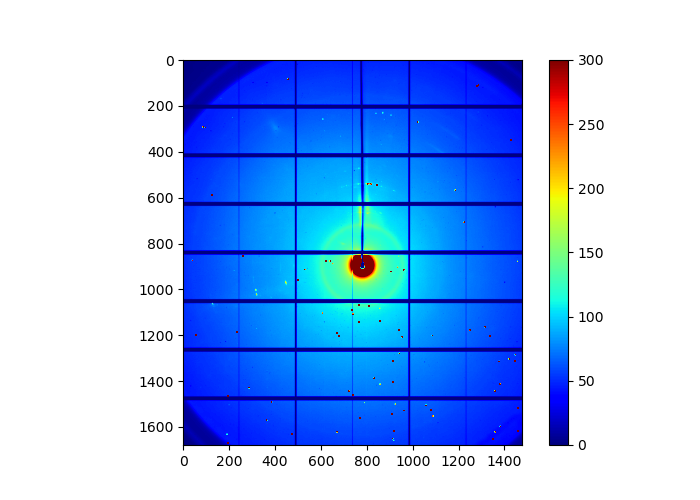

../../../DATA_FAST/SAXS/MARS_CEA_2204/results/Ni_image (median).tiff


In [14]:
to_save = True
save_path = Path(path_res, f'Ni_image (median).tiff')

fig = plt.figure(figsize=(7, 5))
pos = plt.imshow(IMG_med, cmap='jet')
plt.clim(0, 300)
fig.colorbar(pos)
plt.show()


if to_save:
    plt.savefig(save_path)
    print(save_path)

<IPython.core.display.Javascript object>


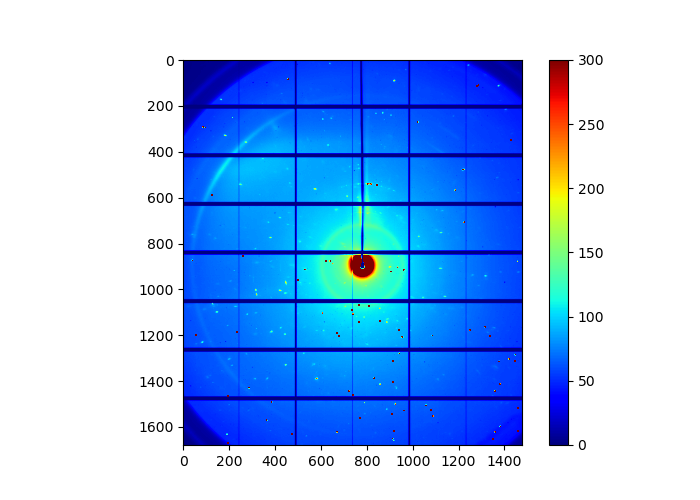

../../../DATA_FAST/SAXS/MARS_CEA_2204/results/Ni_image (mean).tiff


In [18]:

to_save = True
save_path = Path(path_res, f'Ni_image (mean).tiff')

fig = plt.figure(figsize=(7, 5))
pos = plt.imshow(IMG_mean, cmap='jet')
plt.clim(0, 300)
fig.colorbar(pos)
plt.show()


if to_save:
    plt.savefig(save_path)
    print(save_path)

# Integration du signal median Ni

In [61]:
# path geometry
geom_path = Path(path_ut, 'geom.poni')

# path mask
mask_path = Path(path_ut, "mask.edf")
# Open the mask
mask = fabio.open(mask_path)
mask = mask.data

# Let's load the .poni 
ai = pyFAI.load(str(geom_path))



save_path = None


IMG_path = BdF_path
f = h5py.File(IMG_path, "r")
IMGs_BdF = f['_']['scan_data']['data_01']
# I don't know why there are 11 images on the BdF.. I take the first one
IMG_BdF = np.zeros((IMGs.shape[1], IMGs.shape[2]))
IMG_BdF = IMGs_BdF[0,:,:]

res_BdF = ai.integrate1d(IMG_BdF,
                         npt = 5000,
                         unit = "q_nm^-1", # We want to use 2 theta in degree 
                         mask = mask, # (1 for masked pixels, and 0 for valid pixels is the pyFAI standard)
                         #radial_range = r_rng,
                         filename = save_path)



IMG_path = Ni_path
ii = 15
jj = 13

f = h5py.File(IMG_path, "r")
IMGs = f['_']['scan_data']['data_01']
IMG_Ni = np.zeros((IMGs.shape[1], IMGs.shape[2]))
IMG_Ni = IMGs[ii, jj,:,:]


res_Ni = ai.integrate1d(IMG_Ni,
                         npt = 5000,
                         unit = "q_nm^-1", # We want to use 2 theta in degree 
                         mask = mask, # (1 for masked pixels, and 0 for valid pixels is the pyFAI standard)
                         #radial_range = r_rng,
                         filename = save_path)

save_path = Path(path_res, 'Ni_med_qIdI.dat')
res_med = ai.integrate1d(IMG_med,
                         npt = 5000,
                         unit = "q_nm^-1", # We want to use 2 theta in degree 
                         mask = mask, # (1 for masked pixels, and 0 for valid pixels is the pyFAI standard)
                         #radial_range = r_rng,
                         filename = save_path)

<IPython.core.display.Javascript object>


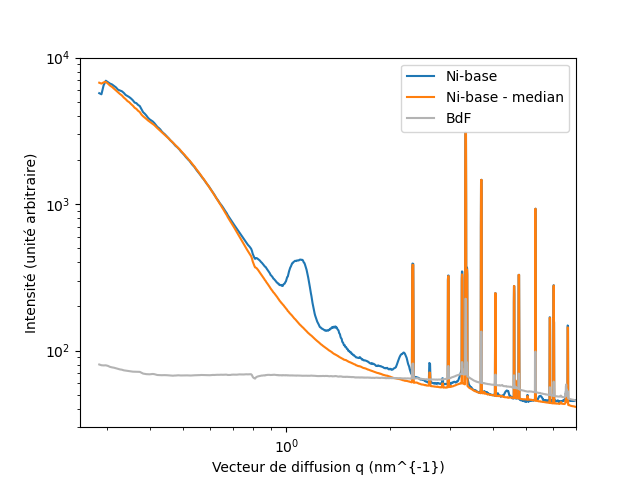

../../../DATA_FAST/SAXS/MARS_CEA_2204/results/Courbes I(q) Base-Ni.tiff


In [62]:
# Pour la normalization, je fait quelquechose de très simple et sans doute un peu faux mais qui donne une approximation, car je n'ai pas toutes les infos:
# - Je ne trouve pas les valeurs de compteur amont/aval donc je choisis une transmission pas trop bete
Tr_Ni = 0.05 # 5%
# - Je normalise par le temps de comptage plutot que par le flux incident (compteur amont)... Comme les temps de comptage sont identique je divise par 1...

I_BdF = res_BdF.intensity * Tr_Ni
I_Ni = res_Ni.intensity - I_BdF
I_Ni_med = res_med.intensity - I_BdF

# Je ne corrige pas l'intensité pour l'instant...


to_save = True
save_path = Path(path_res, f'Courbes I(q) Base-Ni.tiff')


plt.figure()

plt.plot(res_Ni.radial, I_Ni, label='Ni-base')
plt.plot(res_med.radial, I_Ni_med, label='Ni-base - median')
plt.plot(res_BdF.radial, I_BdF, color=[0.7, 0.7, 0.7], label='BdF')

plt.xlim([0.25, 7])
plt.ylim([3e1, 1e4])
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel('Vecteur de diffusion q (nm^{-1})')
plt.ylabel('Intensité (unité arbitraire)')

plt.show()

if to_save:
    plt.savefig(save_path)
    print(save_path)

In [58]:
# Save les data pour SASView
save_path = Path(path_res, 'Ni_med_qIdI.dat')
ai.integrate1d(IMG_med,
                         npt = 5000,
                         unit = "q_A^-1", # We want to use 2 theta in degree 
                         mask = mask, # (1 for masked pixels, and 0 for valid pixels is the pyFAI standard)
                         radial_range = [0.03, 0.231],
                         error_model = "poisson",
                         filename = save_path)


### On  peu faire un premier fit rapide en prenant un modele de cubes
#### --> La normalisaiton est loin d'etre parfaite et les intensités ne sont pas normalisée donc il faut resté prudent sur les valeurs du fit... C'est juste un appercut.

J'utilise SASView pour faire ça

Avec un modèle monodisperse :


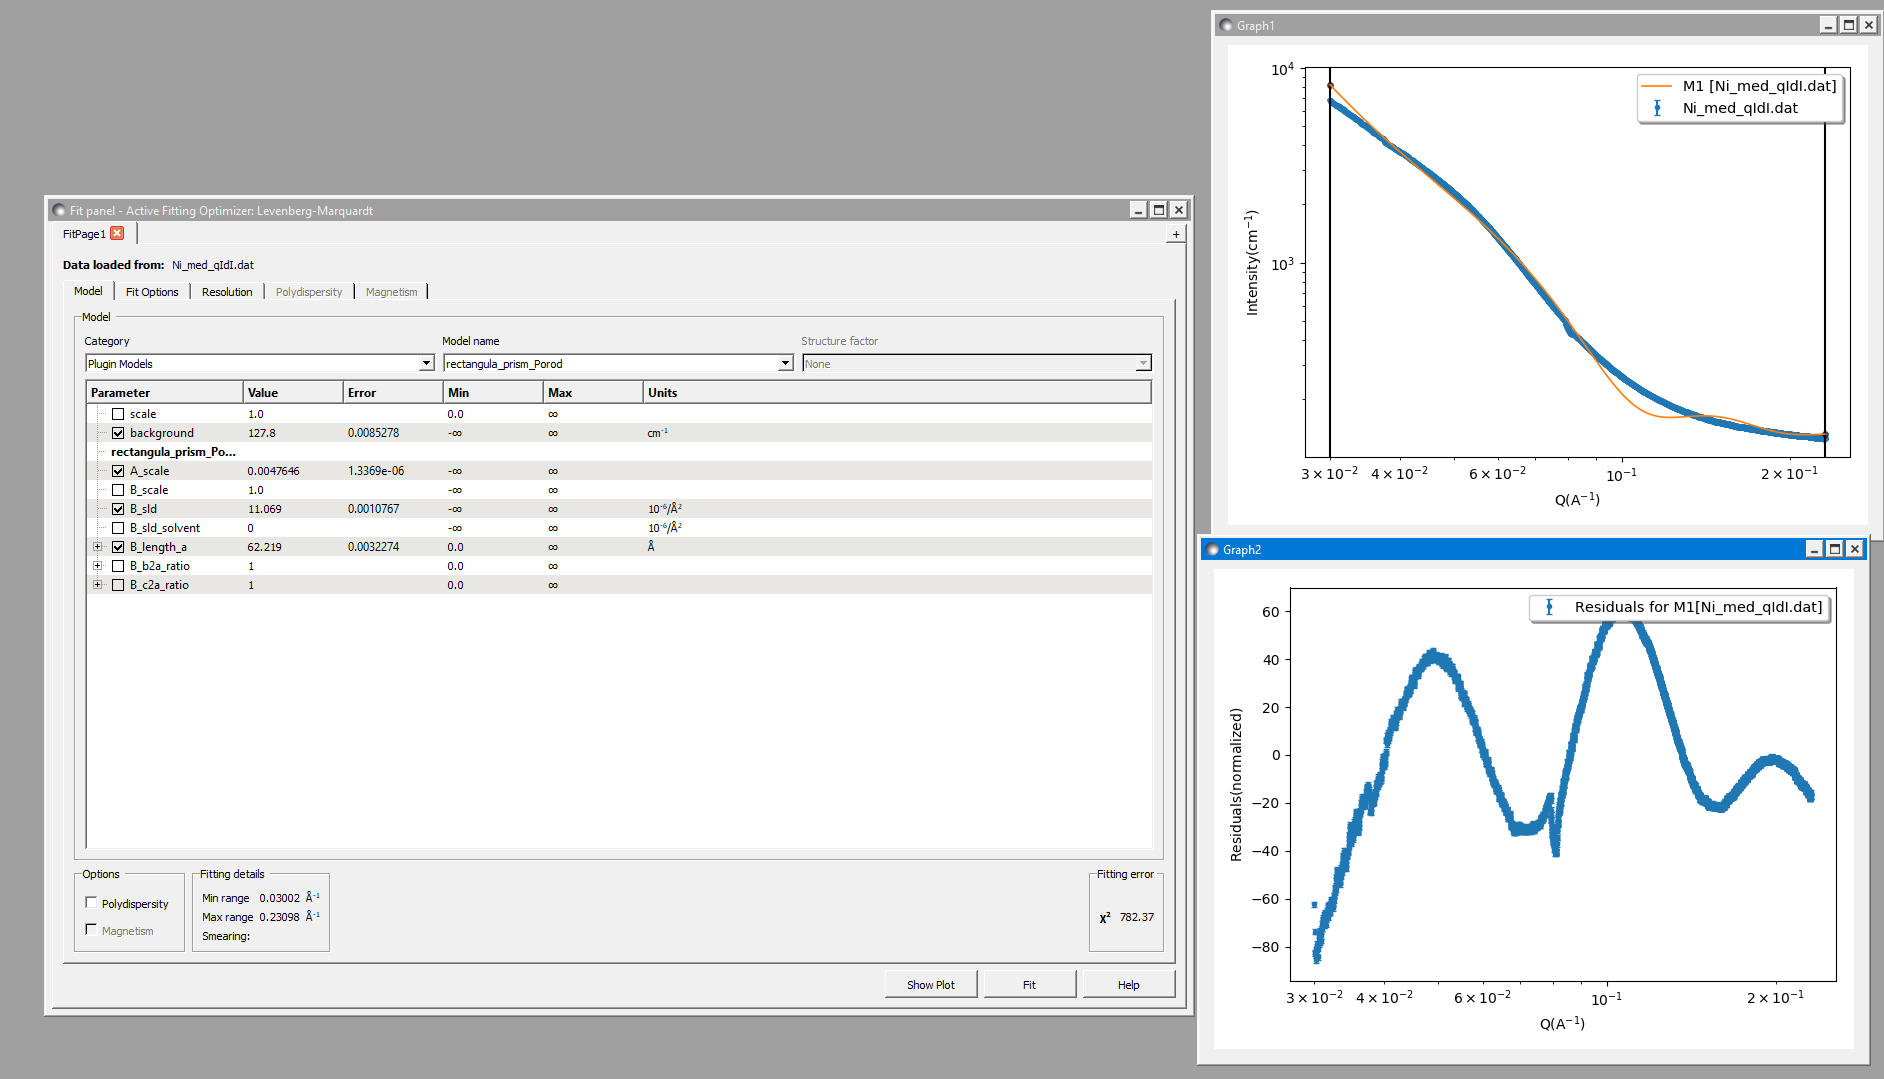

In [63]:
from IPython.display import Image
Image(filename=Path(path_res, 'res_SASView_Ni_med_cube_mono.png')) 

Avec un modèle polydisperse :

In [ ]:
Image(filename=Path(path_res, 'res_SASView_Ni_med_cube_poly_0.2.png')) 

# TESTs

In [64]:
IMG_path = L55_path

f = h5py.File(IMG_path, "r")

print(list(f['_']))


print(list(f['_']['MARS']))

print('===========')
print(list(f['_']['scan_data']))


print('-----')
#print(list(f['_']['scan_data']['data_01']))
print('-----')
#print(list(f['_']['scan_data']['data_02']))

print('-----')
print(list(f['_']['scan_data']['sensors_rel_timestamps']))

['MARS', 'User', 'duration', 'end_time', 'experiment_identifier', 'run_cycle', 'scan_config', 'scan_data', 'start_time', 'title']
['ans__ca__machinestatus_#2', 'd03-1-c01__ex__fent_h1_#2', 'd03-1-c01__ex__fent_v1_#2', 'd03-1-c02__op__mir1-mt_c_#2', 'd03-1-c02__op__mir1-mt_rx_#2', 'd03-1-c03__op__mono1_old_#2', 'd03-1-c04__ex__fent_al_#2', 'd03-1-c04__op__mir2-mt_c_#2', 'd03-1-c04__op__mir2-mt_rs_#2', 'd03-1-c04__op__mir2-mt_rx_#2', 'd03-1-c04__op__mir2-mt_tz_#2', 'd03-1-c05__ex__fent_h2_#2', 'd03-1-c05__ex__fent_v2_#2', 'd03-1-cx0__ex__spare1-mt_#2', 'd03-1-cx0__ex__spare2-mt_#2', 'd03-1-cx0__ex__spt_mf-mt_rx_#2', 'd03-1-cx0__ex__spt_mf-mt_rz_#2', 'd03-1-cx0__ex__spt_mf-mt_ts_#2', 'd03-1-cx0__ex__spt_mf-mt_tx_#2', 'd03-1-cx0__ex__spt_mf-mt_tz.1_#2', 'd03-1-cx0__ex__spt_mf-mt_tz.2_#2', 'd03-1-cx2__ex__dif-mt_rx.1_#2', 'd03-1-cx2__ex__dif-mt_rx.2_#2', 'd03-1-cx2__ex__gonio-mt_rs_#2', 'd03-1-cx2__ex__gonio-mt_rz_#2', 'd03-1-cx2__ex__gonio-mt_ts_#2', 'd03-1-cx2__ex__gonio-mt_tx_#2', 'd03-1